#### 주제 : 장마철 태양광 발전 공백 분석: ESS 최소 필요 용량 산정

목적 : 장마철 강수량이 태양광 발전량에 미치는 영향을 분석하고
       전력 공백을 메우기 위한 ESS(에너지저장장치) 필요 용량 계산

데이터:
 - 장마철(6~7월), 비장마철(4~5월)
 - 강수량: 2020~2025년 서울 4~7월 월별 데이터
 - 일사량: 2020~2025년 서울 4~7월 월별 데이터

분석 질문
 - 장마철 태양광 발전량이 평시 대비 얼마나 감소하나?
 - 연속으로 발전량이 낮은 기간(공백기)은 며칠인가?
 - 이 기간을 버티려면 ESS 용량이 얼마나 필요한가?
 - 지역별로 필요 용량이 다른 이유는(지역별은 일단 보류/현재는 서울만)

In [11]:
# 라이브러리 임포트 및 기본 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'   # Windows
plt.rcParams['axes.unicode_minus'] = False      # 마이너스 기호 깨짐 방지
plt.rcParams['figure.dpi'] = 100                # 그래프 해상도

1. 강수량 데이터 로드

In [23]:
import pandas as pd

# 함수 정의
def load_weather_csv(file_path):
    start_row = None
    with open(file_path, encoding='cp949') as f:
        for i, line in enumerate(f):
            if '지점번호' in line:
                start_row = i
                break
    
    df = pd.read_csv(file_path, encoding='cp949', skiprows=start_row, engine='python')
    df.columns = df.columns.str.strip().str.replace('"', '')
    df['일시'] = pd.to_datetime(df['일시'].astype(str).str.strip(), errors='coerce')
    df = df.dropna(subset=['일시']).sort_values('일시').reset_index(drop=True)
    
    return df

# 파일 로드
weather_67 = load_weather_csv('seoul_weather_6~7.csv')
weather_45 = load_weather_csv('seoul_weather_4~5.csv')

print("\n장마철 강수량:")
print(weather_67.head())

print("\n비장마철 강수량:")
print(weather_45.head())


장마철 강수량:
   지점번호 지점명         일시  강수량(mm)  일최다강수량(mm)    일최다강수량일자  1시간최다강수량(mm)  \
0   108  서울 2020-06-01    139.6        64.7  2020-06-30          15.9   
1   108  서울 2020-07-01    270.4       103.1  2020-07-23          27.1   
2   108  서울 2021-06-01    104.6        38.2  2021-06-27          37.7   
3   108  서울 2021-07-01    168.3        67.4  2021-07-19          65.7   
4   108  서울 2022-06-01    393.8       176.2  2022-06-30          34.4   

   1시간최다강수량일자  Unnamed: 8  
0  2020-06-30         NaN  
1  2020-07-29         NaN  
2  2021-06-27         NaN  
3  2021-07-19         NaN  
4  2022-06-23         NaN  

비장마철 강수량:
   지점번호 지점명         일시  강수량(mm)  일최다강수량(mm)    일최다강수량일자  1시간최다강수량(mm)  \
0   108  서울 2020-04-01     16.9        10.3  2020-04-19           3.9   
1   108  서울 2020-05-01    112.4        29.8  2020-05-18          19.8   
2   108  서울 2021-04-01    124.1        56.2  2021-04-03          11.5   
3   108  서울 2021-05-01    183.1        66.9  2021-05-16          11.3   
4   108

2. 일사량 데이터 로드

In [28]:
def load_solar_csv(file_path):
    df = pd.read_csv(file_path, encoding='cp949', skiprows=17, engine='python')
    df.columns = df.columns.str.strip()
    df['일시'] = pd.to_datetime(df['일시'])
    return df.sort_values('일시').reset_index(drop=True)

solar_67 = load_solar_csv('seoul_solar_data_6~7.csv')
solar_45 = load_solar_csv('seoul_solar_data_4~5.csv') 

print("\n장마철 일사량:")
print(solar_67.head())  

print("\n비장마철 일사량:")
print(solar_45.head())  


장마철 일사량:
   지점번호 지점명         일시  일조합(hr)  일조율(%)  일사합(MJ/m2)
0   108  서울 2020-06-01    206.1   46.62      603.98
1   108  서울 2020-07-01    119.4   26.62      464.55
2   108  서울 2021-06-01    185.5   41.96      563.35
3   108  서울 2021-07-01    195.2   43.51      578.30
4   108  서울 2022-06-01    131.9   29.83      440.59

비장마철 일사량:
   지점번호 지점명         일시  일조합(hr)  일조율(%)  일사합(MJ/m2)
0   108  서울 2020-04-01    283.3   71.59      637.52
1   108  서울 2020-05-01    177.9   40.38      564.83
2   108  서울 2021-04-01    208.6   52.74      558.28
3   108  서울 2021-05-01    203.7   46.25      570.50
4   108  서울 2022-04-01    246.4   62.35      615.24


3. 발전량 계산

In [29]:
# MJ/m² → kWh/m² 변환
# 일사량 변환: MJ/m² × 0.2778 = kWh/m²
solar_67['일사량(kWh/m²)'] = solar_67['일사합(MJ/m2)'] * 0.2778
solar_45['일사량(kWh/m²)'] = solar_45['일사합(MJ/m2)'] * 0.2778

# 발전량 계산 (패널 20m², 효율 18%, 손실 20%)
solar_67['발전량(kWh)'] = solar_67['일사량(kWh/m²)'] * 20 * 0.18 * 0.8
solar_45['발전량(kWh)'] = solar_45['일사량(kWh/m²)'] * 20 * 0.18 * 0.8

# 전체 컬럼 확인
print("장마철:")
print(solar_67)

print("\n비장마철:")
print(solar_45)

장마철:
    지점번호 지점명         일시  일조합(hr)  일조율(%)  일사합(MJ/m2)  일사량(kWh/m²)    발전량(kWh)
0    108  서울 2020-06-01    206.1   46.62      603.98   167.785644  483.222655
1    108  서울 2020-07-01    119.4   26.62      464.55   129.051990  371.669731
2    108  서울 2021-06-01    185.5   41.96      563.35   156.498630  450.716054
3    108  서울 2021-07-01    195.2   43.51      578.30   160.651740  462.677011
4    108  서울 2022-06-01    131.9   29.83      440.59   122.395902  352.500198
5    108  서울 2022-07-01    140.1   31.22      508.79   141.341862  407.064563
6    108  서울 2023-06-01    195.1   44.13      572.17   158.948826  457.772619
7    108  서울 2023-07-01    146.1   32.55      478.80   133.010640  383.070643
8    108  서울 2024-06-01    285.6   64.60      714.52   198.493656  571.661729
9    108  서울 2024-07-01     96.3   21.48      402.43   111.795054  321.969756
10   108  서울 2025-06-01    191.2   43.25      565.72   157.157016  452.612206
11   108  서울 2025-07-01    174.9   38.99      538.53   149.

4. 데이터 병합

In [30]:
# 장마철
merged_67 = pd.merge(
    weather_67[['일시', '강수량(mm)']],
    solar_67[['일시', '일사량(kWh/m²)', '발전량(kWh)', '일조합(hr)']],
    on='일시'
)

# 비장마철
merged_45 = pd.merge(
    weather_45[['일시', '강수량(mm)']],
    solar_45[['일시', '일사량(kWh/m²)', '발전량(kWh)', '일조합(hr)']],
    on='일시' # 같은 날짜끼리 붙이기
)

# 발전량 비교

print("="*30)
print("발전량 분석")
print("="*30)

avg_power_67 = merged_67['발전량(kWh)'].mean()
avg_power_45 = merged_45['발전량(kWh)'].mean()
power_loss = avg_power_45 - avg_power_67
loss_percent = (power_loss / avg_power_45) * 100

print(f"\n비장마철 평균 발전량: {avg_power_45:.0f} kWh")
print(f"장마철 평균 발전량: {avg_power_67:.0f} kWh")
print(f"→ 장마철 감소: {power_loss:.0f} kWh ({loss_percent:.1f}% 감소)")


발전량 분석

비장마철 평균 발전량: 484 kWh
장마철 평균 발전량: 429 kWh
→ 장마철 감소: 55 kWh (11.4% 감소)


5. 상관관계 분석

In [ ]:
# corr 파이썬 코드

# 상관계수 (강수량과 발전량을 -1~1 사이 숫자로 표현)
# -1에 가까우면: 강수량 많을수록 발전량 적음 (강한 음의 관계)
# 0에 가까우면: 관계 없음
# +1에 가까우면: 강수량 많을수록 발전량 많음 (강한 양의 관계)

# 추세선 계산 (y = ax + b 형태의 직선 방정식 만들기)
# z_67[0] = 기울기(a) → 비 1mm 증가 시 전기 변화량
# z_67[1] = 절편(b) → 비가 0mm일 때 기본 전기량

# z_67 = np.polyfit(
#     merged_67['강수량(mm)'],  # x축: 비 온 양
#     merged_67['발전량(kWh)'],   # y축: 만든 전기
#     1                           # 1차 방정식 (직선)
# )

# abs(): 절댓값 (음수를 양수로)
# z_67[0]*100: 기울기 × 100 (비 100mm 증가 효과) -> mm는 크기가 작아서 체감 안되므로
# :.0f: 소수점 없이 정수로 표시

In [31]:
print("\n" + "="*30)
print("상관관계 분석")
print("="*30 + "\n")

# 장마철 상관관계
corr_67 = merged_67[['강수량(mm)', '발전량(kWh)']].corr().iloc[0, 1]
z_67 = np.polyfit(merged_67['강수량(mm)'], merged_67['발전량(kWh)'], 1)

# 비장마철 상관관계
corr_45 = merged_45[['강수량(mm)', '발전량(kWh)']].corr().iloc[0, 1]
z_45 = np.polyfit(merged_45['강수량(mm)'], merged_45['발전량(kWh)'], 1)

print(f"장마철 상관계수: {corr_67:.3f}")
print(f"  → 강수량 100mm ↑ → 발전량 {abs(z_67[0]*100):.0f}kWh ↓")
print(f"\n비장마철 상관계수: {corr_45:.3f}")
print(f"  → 강수량 100mm ↑ → 발전량 {abs(z_45[0]*100):.0f}kWh ↓")


상관관계 분석

장마철 상관계수: -0.825
  → 강수량 100mm ↑ → 발전량 37kWh ↓

비장마철 상관계수: -0.340
  → 강수량 100mm ↑ → 발전량 33kWh ↓


6. ESS 용량 계산

In [32]:
print("\n" + "="*30)
print("ESS 필요 용량 (일반 가정 기준)")
print("="*30 + "\n")

PANEL_AREA = 20  # m²
MONTHLY_NEED = 400 # 4인 가족 평균 한 달 동안 필요한 전기량 = 400kWh
worst = merged_67.loc[merged_67['발전량(kWh)'].idxmin()] # 장마철 중에서 발전량이 가장 적었던 달
shortage = max(0, MONTHLY_NEED - worst['발전량(kWh)']) # 필요한 전기 - 만든 전기 = 부족한 전기
                                                       # max(0,...) -> max(0, -100) = 0 음수 대신 0출력, 부족하지 않으면 0으로
recommended = shortage * 1.2    # 부족량에 20% 여유분 추가
commercial = int(np.ceil(recommended / 10)) * 10 # 상용 제품 단위로 올림 (실제 제품: 10kWh, 20kWh, 30kWh...단위로 판매)

print(f"\n패널 면적: {PANEL_AREA}m² (약 15개)")
print(f"월 필요량: {MONTHLY_NEED} kWh (4인 가족)")
print(f"평균 발전량: {merged_67['발전량(kWh)'].mean():.0f} kWh")
print(f"최악 발전량: {worst['발전량(kWh)']:.0f} kWh ({worst['일시'].strftime('%Y년 %m월')})")
print(f"부족량: {shortage:.0f} kWh")
print(f"권장 ESS: {commercial} kWh")
print(f"예상 비용: 약 {commercial * 500000:,}원") # 용량 * 단가 = 총 비용
                                                 # 50만원은 ESS 배터리 시장 평균 단가


ESS 필요 용량 (일반 가정 기준)


패널 면적: 20m² (약 15개)
월 필요량: 400 kWh (4인 가족)
평균 발전량: 429 kWh
최악 발전량: 322 kWh (2024년 07월)
부족량: 78 kWh
권장 ESS: 100 kWh
예상 비용: 약 50,000,000원


7. 시각화 (그래프)

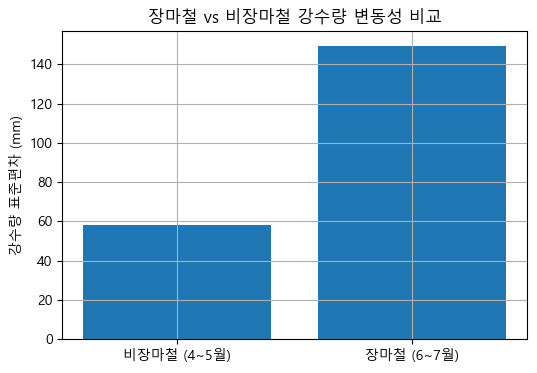

In [33]:
import matplotlib.pyplot as plt

# 1️⃣ 표준편차 계산
std_45 = weather_45['강수량(mm)'].std()
std_67 = weather_67['강수량(mm)'].std()

# 2️⃣ 막대그래프
plt.figure(figsize=(6, 4))

plt.bar(
    ['비장마철 (4~5월)', '장마철 (6~7월)'],
    [std_45, std_67]
)

plt.title('장마철 vs 비장마철 강수량 변동성 비교')
plt.ylabel('강수량 표준편차 (mm)')
plt.grid(True)

plt.show()

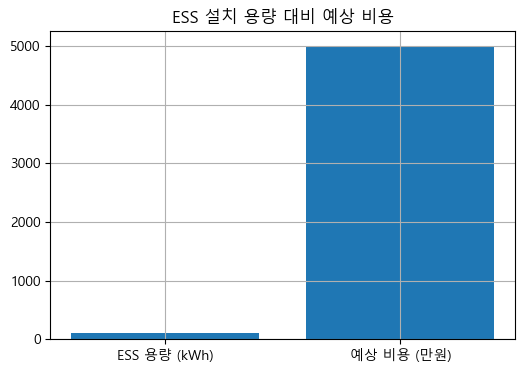

In [34]:
plt.figure(figsize=(6, 4))

plt.bar(
    ['ESS 용량 (kWh)', '예상 비용 (만원)'],
    [commercial, commercial * 50]
)

plt.title('ESS 설치 용량 대비 예상 비용')
plt.grid(True)

plt.show()
